In [66]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import signal
from scipy.signal import find_peaks, savgol_filter, lfilter
from scipy.fft import fft, fftfreq
from scipy.fftpack import fft as fftpackfft, fftshift
# from scipy.stats import signaltonoise
from scipy import stats
import json
import os

import numpy as np
import warnings

warnings.filterwarnings('ignore')

#### Function definitions

In [67]:
def get_column_list(df: pd.DataFrame, column_name: str, start_index: int=0, end_index: int=-1) -> list:
    col = df.iloc[start_index:end_index:][column_name] # ["ax_smooth"]
    col = col.reset_index()[column_name]

    return list(col)

def find_peak_spectrum(spectrum: np.ndarray, freq: np.ndarray, prominence: float=1) -> int:
    peaks_spectrum, _ = find_peaks(spectrum, prominence=prominence)
    peaks_spectrum = peaks_spectrum[:(int(len(peaks_spectrum)/2)+1)]
    peak_index = peaks_spectrum[np.argmax(np.abs(spectrum[peaks_spectrum]))]

    max_val = spectrum[peak_index]
    max_val_freq = freq[peak_index]

    return peak_index, max_val, max_val_freq

def get_fft_values(timeseries: list, samplerate: int, absolute:bool=False, filter_dc:bool=True) -> np.ndarray:
    if filter_dc:
        freq_start_index = 1
    else:
        freq_start_index = 0

    if absolute:
        spectrum = np.abs(fft(timeseries))[freq_start_index:]
    else:
        spectrum = fft(timeseries)[freq_start_index:]
    
    freq = fftfreq(len(timeseries),1/samplerate)[freq_start_index:]

    return spectrum, freq

def load_dataset(file_name: str, file_dir: str):
    file_path = os.path.join(file_dir,file_name)

    if file_name.endswith("json"):
        with open(file_path) as file:
            data = json.load(file)

        # create dataframe
        ds = [d["measurement"] for i,d in enumerate(data[0]) if i != 0 and i < len(data[0])*0.99 and d["measurement"]["gathering_type"] == "logging_data"]
        df = pd.DataFrame(ds)

        df["ax"] = df["acc_x"]
        df["ay"] = df["acc_y"]
        df["az"] = df["acc_z"]
    else:
        df = pd.read_csv(file_path)

    activity = file_name.split("_")[0]
    position = file_name.split("_")[1]

    return df, activity, position

def create_and_get_plot_dir(plot_base_dir: str, activity: str, position: str, create_dir=True) -> str:
    plot_dir = os.path.join(plot_base_dir,f"{activity}_{position}")
    if create_dir:
        if not os.path.exists(plot_dir):
            os.makedirs(plot_dir)

    return plot_dir

def print_and_save_activity_plot(df:pd.DataFrame,cols:list,sample_rate:int,device:str,activity:str,position:str,start_index:int=0,end_index:int=-1,
                                 base_sample_rate:int=100,save_fig:bool=False,filter:str=None,plot_dir:str=None,
                                 draw_peaks:bool=False,prominence:float=1):
    if filter is not None:
        title = f"filter: {filter} | {device} | {activity} sensor_pos:{position}: {sample_rate} Hz"
    else:
        title = f"{device} | {activity} sensor_pos:{position}: {sample_rate} Hz"

    df_slice = df.iloc[start_index:end_index,:]

    fig = df_slice.plot.line(y=cols).set_title(
                    title).get_figure()
    
    if draw_peaks:
        abs_start_index = int(start_index/sample_rate*base_sample_rate)
        figure_markers = ["o","x","d","+","*","s"]
        for i,column_name in enumerate(cols):
            col_series = df_slice[column_name]
            peaks,_ = find_peaks(np.abs(col_series),prominence=prominence)
            
            if len(peaks) > 0:
                peak_values = np.array(col_series)[peaks]
                plt.plot(np.int_(peaks*(base_sample_rate/sample_rate))+abs_start_index,peak_values,figure_markers[i])

    if (save_fig is True) and (plot_dir is not None) and (os.path.exists(plot_dir)):
        fig.savefig(os.path.join(plot_dir,f"{sample_rate}_plot_{filter}_{start_index}_{end_index}.png"))

    plt.show()

def plot_and_save_spectrum(freq,spectrum,column_name,max_val,max_val_freq,start_index,end_index,save_fig=False,plot_dir=None,
                           normalize=True,absolute=False,xlim=[-3,3]):
    if absolute:
         name_placeholder = "abs"
    else:
         name_placeholder = ""

    plt.title(f'{name_placeholder} spectrum["{column_name}"]: {max_val:.4f} @ {max_val_freq:.4f} Hz')
    plt.xlim(xlim)
    
    if (save_fig is True) and (plot_dir is not None) and (os.path.exists(plot_dir)):
            plt.savefig(os.path.join(plot_dir,f"spectrum_plot_{name_placeholder}_{column_name}_{start_index}_{end_index}.png"))

    plt.show()

def filter_df_columns(df: pd.DataFrame, device,column_names_to_filter: list=["ax","ay","az"], 
                      column_names_to_add: list=["ax_smooth","ay_smooth","az_smooth"],
                      filter_window_size: int=100, poly_dim: int=5) -> pd.DataFrame:

    # iphone measures in m/s² 1g=9.81m/s²
    if device == "iphone":
        df[column_names_to_filter]=df[column_names_to_filter]/9.81
    if device == "ruuvi":
        df["az"] = df["az"] - 1

    filter_window_size = min(filter_window_size,int(len(df)/50))

    if filter_window_size == 0:
        filter_window_size = 1

    if poly_dim >= filter_window_size:
        poly_dim = max(0,filter_window_size-1)

    for i,name in enumerate(column_names_to_add):
        df[name] = savgol_filter(list(df[column_names_to_filter[i]]),filter_window_size,poly_dim)

    return df

def resample_df(df: pd.DataFrame, resample_rates: list, base_sample_rate: int=100) -> list:
    return [df.loc[::int(base_sample_rate/sample_rate),:] for sample_rate in resample_rates]

## Configuration

In [68]:
file_base_dir = "data"
plot_base_dir = "plots"

device = "iphone"

save_fig = False

base_sample_rate = 100
resample_rates = [1,2,5,10,25,50,100]
freq_checks = [0,0.5,1,2.5,5,12.5,25]
filter_dc = True

xlim_vals_spectrum = [5,15]

filter_window_size = 100
poly_dim = 5

column_names = ["ax","ay","az"]
filter_column_names = ["ax_smooth","ay_smooth","az_smooth"]
all_column_names = column_names + filter_column_names

## Activity
### Load data

In [69]:
file_names = [file for file in os.listdir(file_base_dir)]

file_name = "walking_hand_acceleration.csv"

['jogging_hand_acceleration.csv', 'sprinting_hand_acceleration.csv', 'squat_hand_acceleration.csv', 'walking_hand_acceleration.csv']


In [71]:
if file_name == "walking_hand_acceleration.csv":
    sample_start_index = 1700
    sample_end_index = -1
elif file_name == "jogging_hand_acceleration.csv":
    sample_start_index = 1400
    sample_end_index = 4000
elif file_name == "squat_hand_acceleration.csv":
    sample_start_index = 2400
    sample_end_index = 6800
elif file_name == "sprinting_hand_acceleration.csv":
    sample_start_index = 2650
    sample_end_index = 3300
else:
    sample_start_index = 0
    sample_end_index = -1



# file_name = "walking_hand_5_10.json"
# device = "ruuvi"

df, activity, position = load_dataset(file_name,file_base_dir)
plot_dir = create_and_get_plot_dir(plot_base_dir, activity, position)

resample_dfs = [filter_df_columns(rdf,device,poly_dim=5,column_names_to_filter=column_names,column_names_to_add=filter_column_names) for rdf in resample_df(df,resample_rates,base_sample_rate)]
df = filter_df_columns(df,device,column_names_to_filter=column_names,column_names_to_add=filter_column_names)

df.head()

,time,ax,ay,az,atotal,ax_smooth,ay_smooth,az_smooth
0,0.006950,0.179409,-0.113150,-0.035678,2.11,0.203555,-0.067418,0.021689
1,0.024223,0.160041,-0.071356,-0.031600,1.74,0.161205,-0.090935,-0.000840
2,0.039912,0.149847,-0.047910,-0.030581,1.57,0.121905,-0.110815,-0.020319
3,0.050021,0.134557,-0.059123,-0.020387,1.45,0.085531,-0.127326,-0.036977
4,0.057691,0.103976,-0.113150,-0.032620,1.54,0.051963,-0.140729,-0.051034


### Plots
#### Timeseries
Here are two plots of the complete timeseries from the original samples, with and without smoothing.

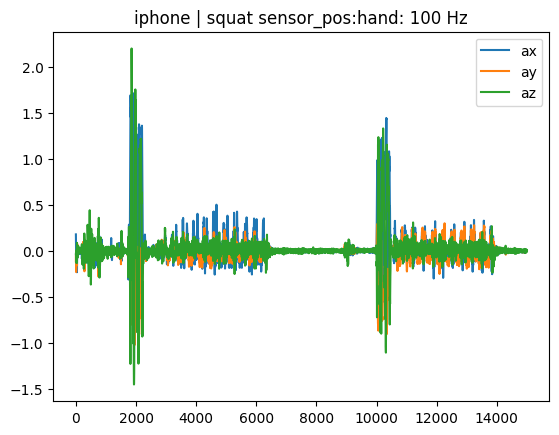

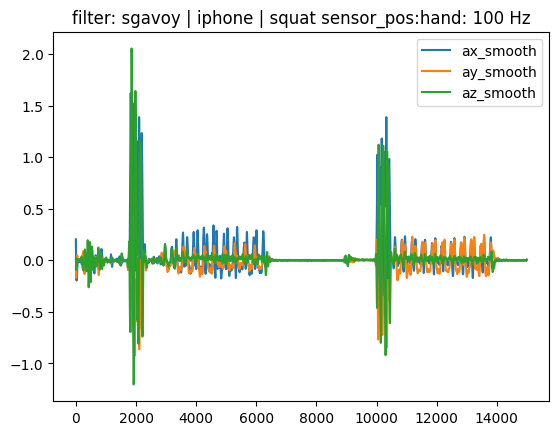

In [73]:
# save_fig = False

print_and_save_activity_plot(df,["ax","ay","az"],base_sample_rate,device,activity,position,
                                save_fig=save_fig,plot_dir=plot_dir)
print_and_save_activity_plot(df,["ax_smooth","ay_smooth","az_smooth"],base_sample_rate,device,activity,position,
                             filter="sgavoy",save_fig=save_fig,plot_dir=plot_dir)

#### Zooming in
In this section a smaller part of the original sample values is selected for closer inspection. Additionally it gets downsampled to lower sampling frequencies to simulate the effect on the clarity of the motion profile. This is done by only picking a certain amount of samples from the original range. For each of the different frequencies (1,2,5,10,25,50,100) the output is plotted and saved.  
Filtering is used to smoothen out the plots and emphasize the base frequency of the activity.  
It can be seen that once the sample frequency goes above 10 Hz that all of the individual peaks are detectable, even though they become significantly more clear when going up to 25 Hz and above. Too many details get lost at 1 or 2 Hz which leads to no clear peaks, ruling these two frequencies out.

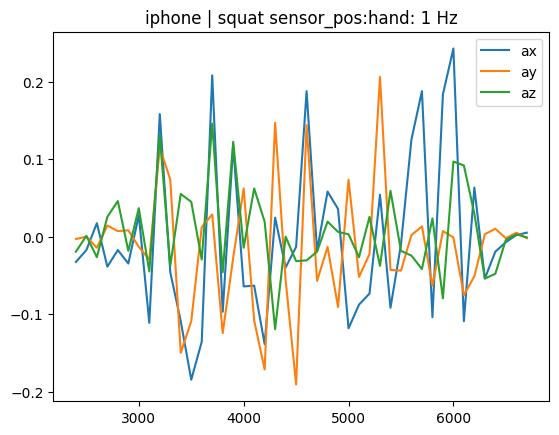

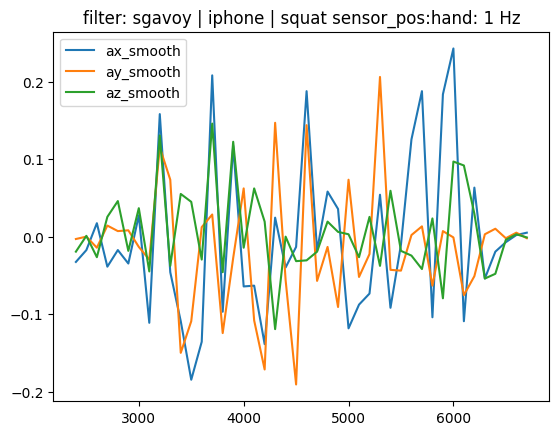

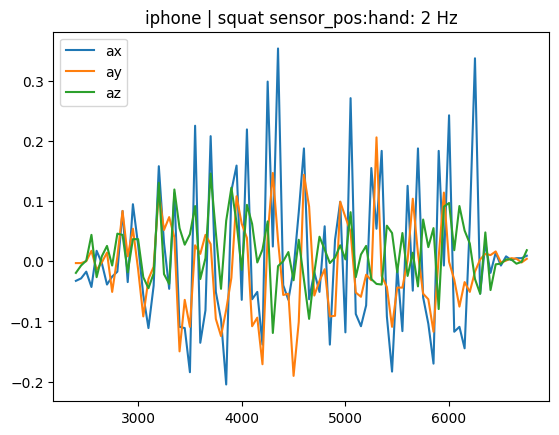

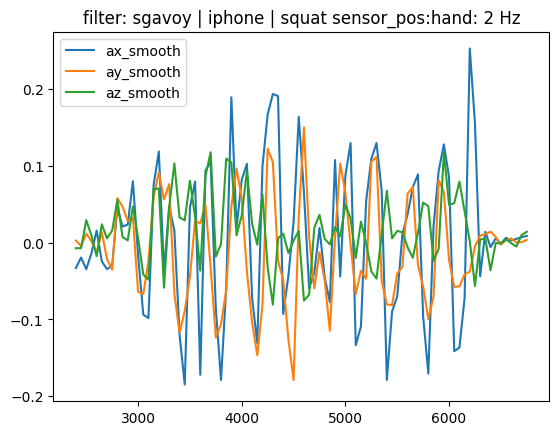

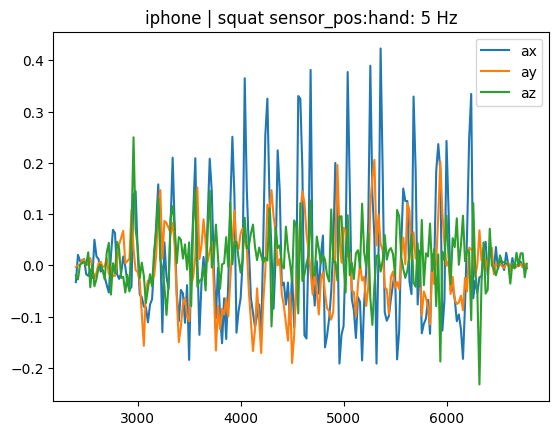

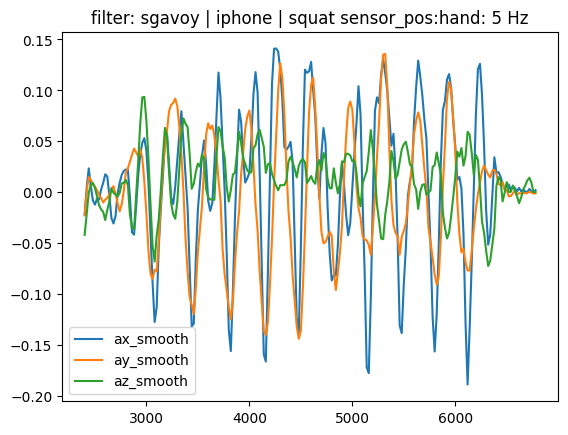

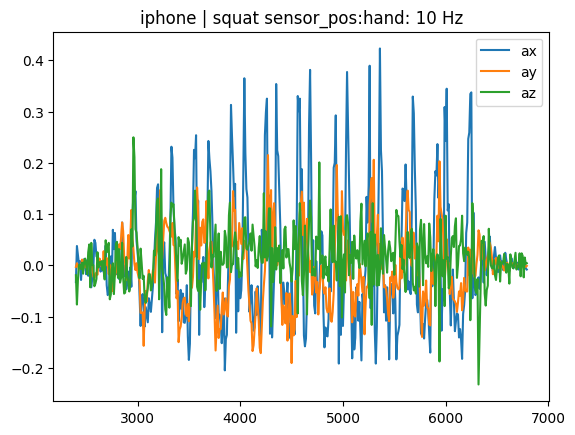

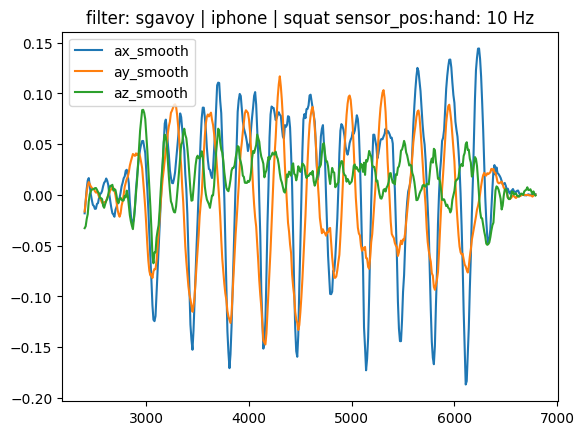

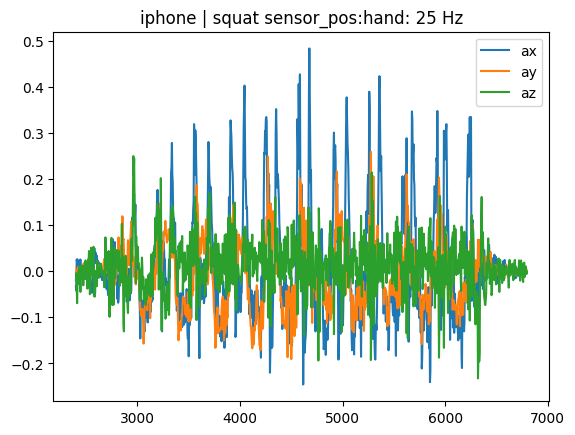

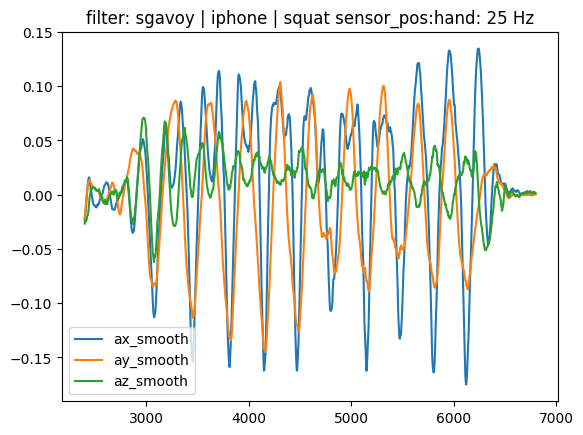

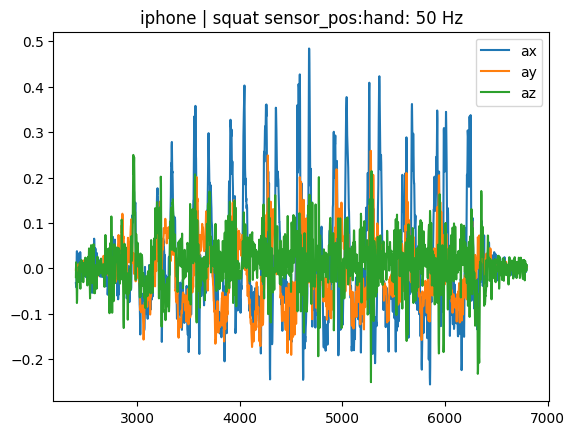

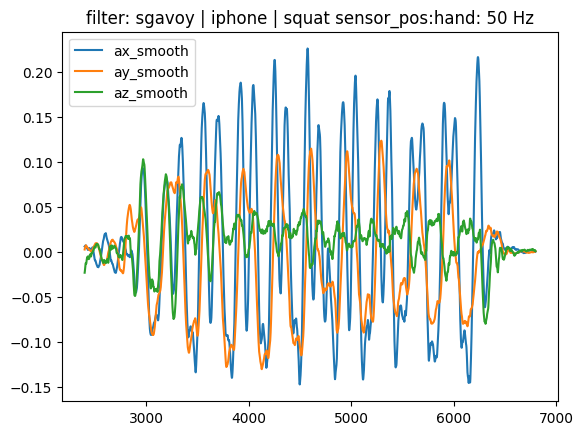

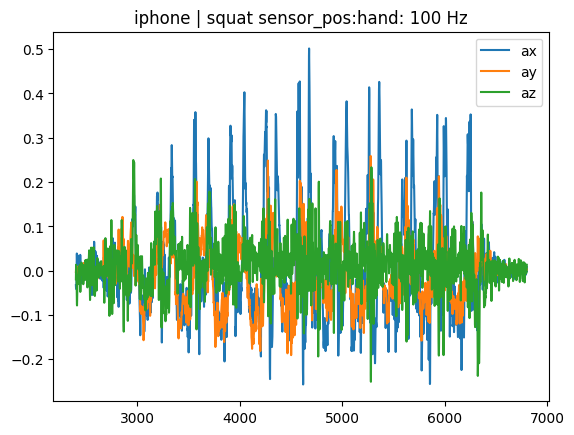

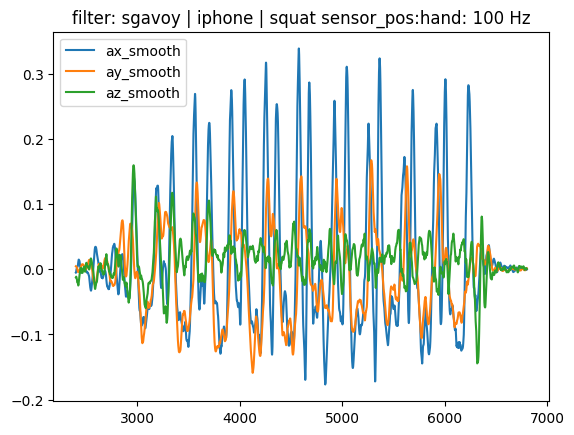

In [74]:
# save_fig = True

for i,rdf in enumerate(resample_dfs):
    resample_rate = resample_rates[i]

    tmp_sample_start_index = int(sample_start_index*resample_rate/base_sample_rate)
    tmp_sample_end_index = int(sample_end_index*resample_rate/base_sample_rate)

    if tmp_sample_end_index == 0:
        tmp_sample_end_index = -1

    # rdf.reset_index(inplace=True)
    print_and_save_activity_plot(rdf,["ax","ay","az"],resample_rate,device,activity,position,tmp_sample_start_index,tmp_sample_end_index,
                                 save_fig=save_fig,plot_dir=plot_dir)
    print_and_save_activity_plot(rdf,["ax_smooth","ay_smooth","az_smooth"],resample_rate,device,activity,position,tmp_sample_start_index,
                                  tmp_sample_end_index,filter="sgavoy",save_fig=save_fig,plot_dir=plot_dir)

#### Create amplitude distribution and CFD

Creation of amplitude distribution and CFD plus additional plots.

max abs acceleration value: 0.5015290519877675 g


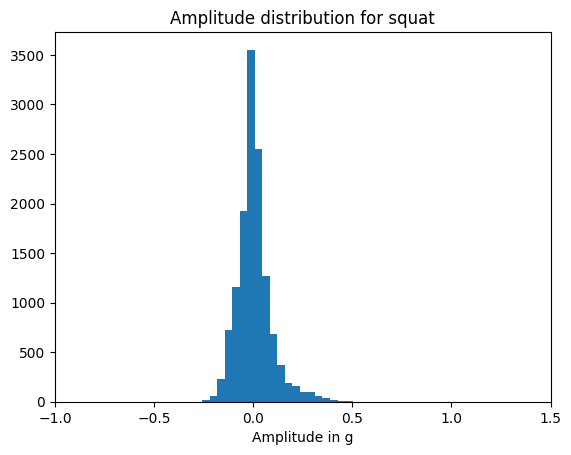

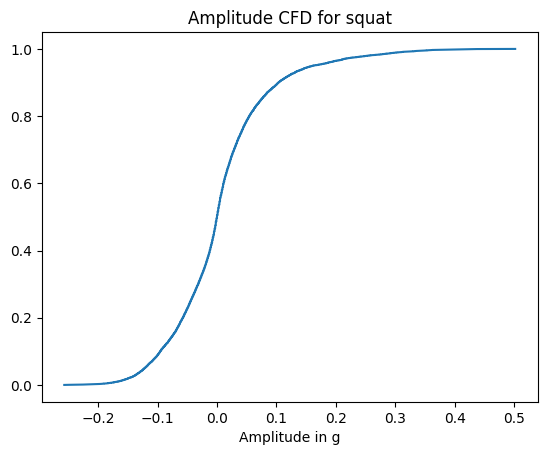

In [75]:
# find values above 2,4,8,16

available_scales = [0,2,4,8,16]

df_peaks = pd.DataFrame(columns = [f"{str(s)}g" for s in available_scales])

timeseries_lists = []

# only look for peaks in raw data
for col_name in column_names:
    timeseries_list = np.array(get_column_list(df,col_name,sample_start_index,sample_end_index))
    timeseries_lists.extend(timeseries_list)

timeseries_lists = np.array(timeseries_lists)

# calculate cfd
timeseries_lists_sorted = np.sort(timeseries_lists)
cfd = np.cumsum(np.abs(timeseries_lists_sorted))
yvals = np.linspace(0,1,len(timeseries_lists))

max_accel = np.max(np.abs(timeseries_lists))
print(f"max abs acceleration value: {max_accel} g")

# plot amplitude distribution
plt.hist(timeseries_lists,bins=20,density=False)
plt.title(f"Amplitude distribution for {activity}")
plt.xlabel("Amplitude in g")
plt.xlim(-(int(max_accel)+1),max_accel+1)
if save_fig:
    plt.savefig(os.path.join(plot_dir,f"amplitude_distribution_{activity}_{sample_start_index}_{sample_end_index}.png"))
plt.show()


# plot amplitude cfd
plt.plot(timeseries_lists_sorted, yvals)
plt.xlabel("Amplitude in g")
plt.title(f"Amplitude CFD for {activity}")
# plt.xlim(-(int(max_accel)+1),max_accel+1)
if save_fig:
    plt.savefig(os.path.join(plot_dir,f"amplitude_cfd_{activity}_{sample_start_index}_{sample_end_index}.png"))
plt.show()

#### FFT
The FFT can be used to quickly get the fourier transform of a given timeseries. This spectrum represents the magnitude of sin- and cosine frequencies occuring in the timeseries and allows to find dominant frequencies.
Here the spectrum and its CFD are calculated and plotted for different axis.

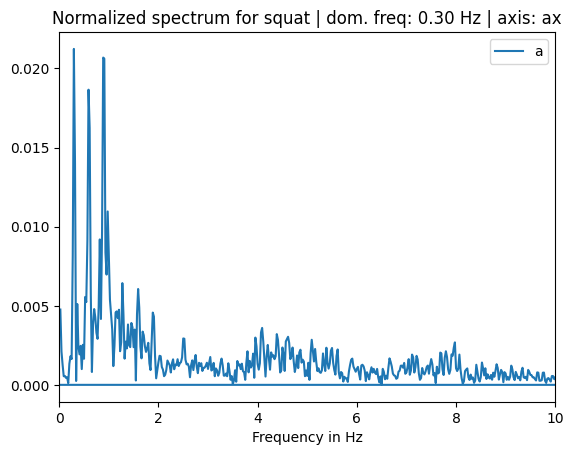

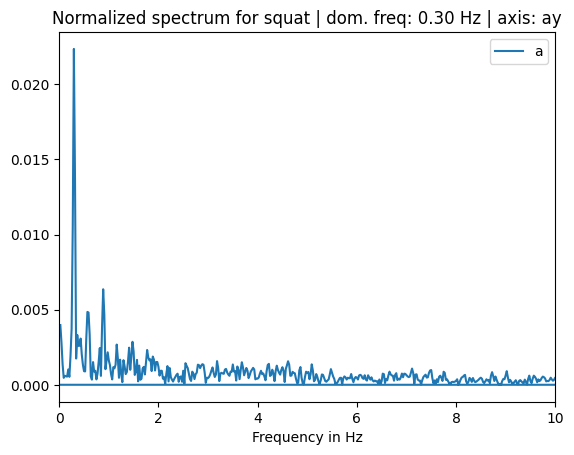

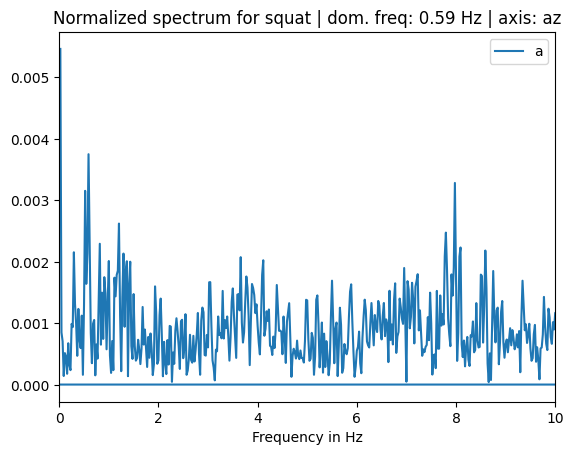

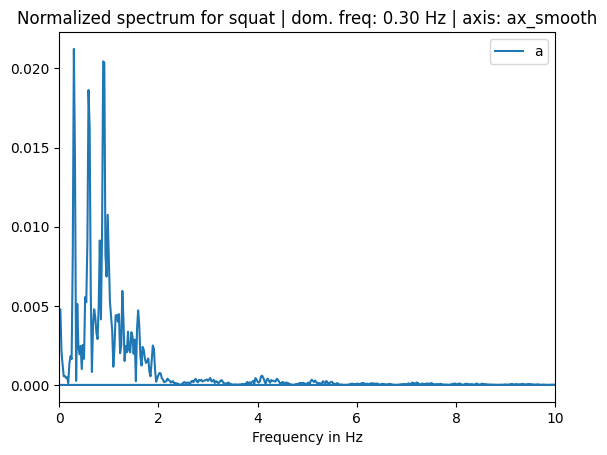

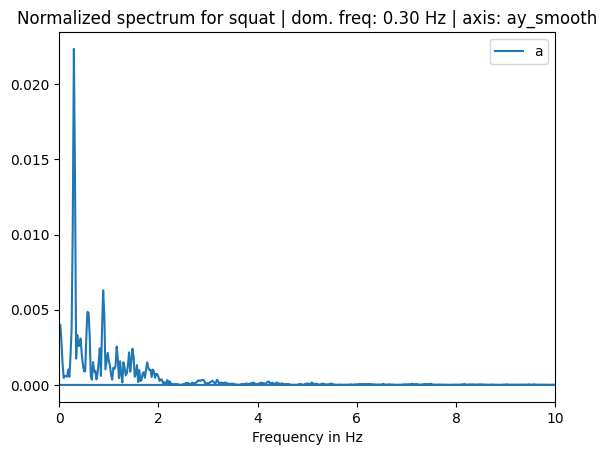

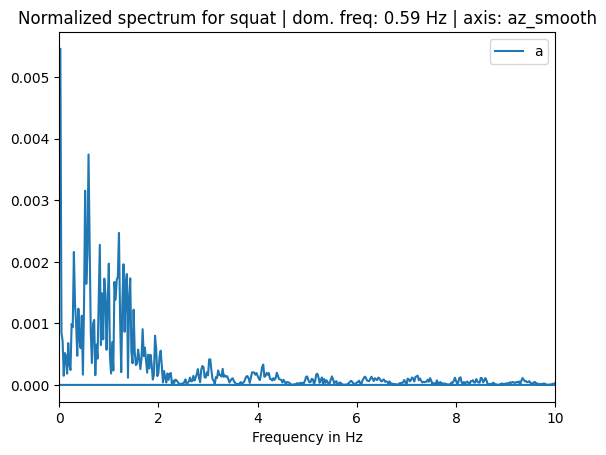

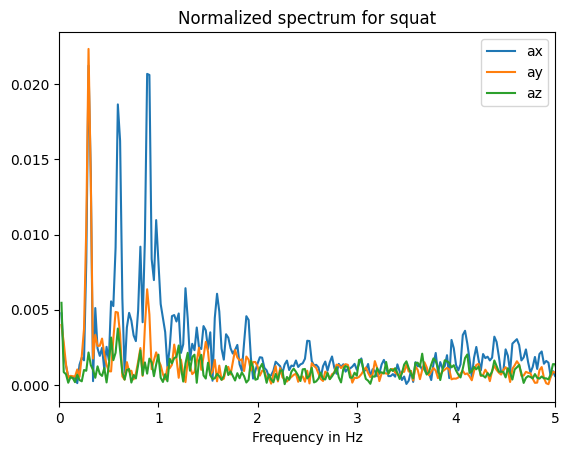

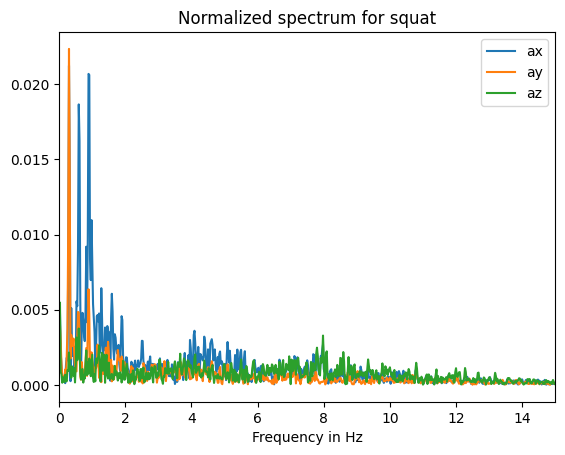

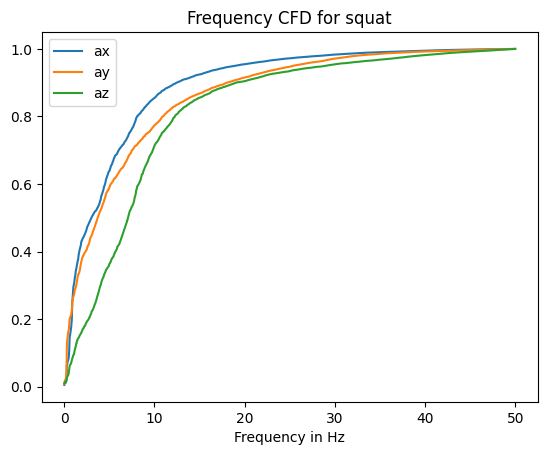

In [76]:
freq_col_names = [str(fr) for fr in freq_checks]
freq_col_names.extend(["activity","axis","is_filtered"])

df_freq_check = pd.DataFrame(columns=freq_col_names)

all_fft_freqs = []
all_fft_values = []
all_axis_values = []
all_cfds = []

for col_name in all_column_names:
    
    if "smooth" in col_name.lower():
        is_filtered = True
    else:
        is_filtered = False

    axis = col_name.split("_")[0]
    
    timeseries_list = get_column_list(df,col_name,sample_start_index,sample_end_index)
    window = signal.hamming(len(timeseries_list))
    timeseries_list *= window

    fft_values,fft_freq = get_fft_values(timeseries_list,base_sample_rate,absolute=False,filter_dc=True)
    fft_values_abs = np.abs(fft_values)
    fft_values_abs_norm = fft_values_abs/len(timeseries_list)

    fft_freqs_abs = np.abs(fft_freq)

    # calculate cfd
    # fft_values_sorted = np.sort(fft_values_abs)
    # cfd = np.cumsum(np.abs(fft_values_sorted))
    cfd = np.cumsum(fft_values_abs[:int(len(fft_values_abs)/2)])

    all_fft_values.append(fft_values_abs_norm)
    all_fft_freqs.append(fft_freq)
    all_axis_values.append(col_name)
    all_cfds.append(cfd)

    peak_index, max_val, max_val_freq = find_peak_spectrum(fft_values_abs, fft_freq)
    spec_sums = [np.sum(fft_values_abs_norm[(fft_freqs_abs > frq)]) for frq in freq_checks]
    spec_sums_rel = spec_sums/np.sum(fft_values_abs_norm)

    plt.plot(fft_freq[:int(len(timeseries_list)/2)],fft_values_abs_norm[:int(len(timeseries_list)/2)])
    plt.title(f"Normalized spectrum for {activity} | dom. freq: {max_val_freq:.2f} Hz | axis: {col_name}")
    plt.xlabel("Frequency in Hz")
    if save_fig:
        plt.savefig(os.path.join(plot_dir,f"spectrum_abs_{col_name}_{activity}_{sample_start_index}_{sample_end_index}"))
    plt.xlim(0,10)
    plt.legend(col_name)
    plt.show()

    df_freq_check.loc[len(df_freq_check)] = list(spec_sums_rel) + [activity] + [axis] + [is_filtered]

df_freq_check.loc[len(df_freq_check)] = list(df_freq_check[[str(fr) for fr in freq_checks]].mean()) + [activity] + ["all"] + ["False"]

# print distribution for ax,ay,az in one plot (view different xlims)
for xlim_val in xlim_vals_spectrum:
    plt.figure()
    for i,fft_value_abs in enumerate(all_fft_values):
        if "smooth" in all_axis_values[i].lower():
            break
        plt.plot(all_fft_freqs[i][:int(len(fft_freq)/2)],fft_value_abs[:int(len(all_fft_freqs[i])/2)])
        plt.title(f"Normalized spectrum for {activity}")
        plt.xlabel("Frequency in Hz")
        plt.xlim(0,xlim_val)
    plt.legend(all_axis_values[:3])
    if save_fig:
        plt.savefig(os.path.join(plot_dir,f"spectrum_abs_all_{activity}_{xlim_val}_{sample_start_index}_{sample_end_index}"))
    plt.show()


# print cfd for ax,ay,az in one plot
yvals = np.linspace(0,1,len(all_cfds[0]))
plt.figure()
for i in range(3):
    plt.plot(all_fft_freqs[i][:int(len(all_fft_freqs[i])/2)], all_cfds[i]/all_cfds[i][-1])
    plt.xlabel("Frequency in Hz")
    plt.title(f"Frequency CFD for {activity}")
    plt.legend(all_axis_values[:3])
if save_fig:
    plt.savefig(os.path.join(plot_dir,f"frequency_cfd_{activity}_{sample_start_index}_{sample_end_index}.png"))
plt.show()


# save to csv
df_freq_check.to_csv(os.path.join(plot_dir,f"spectrum_distribution_abs_{activity}_{sample_start_index}_{sample_end_index}.csv"))